In [1]:
import numpy as np
import sys
import time
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Layer,
    Input,
    InputLayer,
    Flatten,
    Activation,
    Conv2DTranspose,
    Dense)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D)
from keras.activations import *
from keras.models import Model, Sequential
from keras.applications import vgg16, imagenet_utils
import keras.backend as K
import numpy
import math
import matplotlib.pyplot as plt
import PIL


def load_img(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224), resample=PIL.Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array[np.newaxis, :]
    img_array = img_array.astype(np.float)
    img_array = imagenet_utils.preprocess_input(img_array)
    print(img_array.shape)
    return img_array


def visualize_img(img_data, examinate=False):
    if examinate:
        plt.imshow(img_data)
        plt.show()

    print(img_data.shape)
    img_data = img_data - img_data.min()
    img_data *= 1.0 / (img_data.max() + 1e-8)
    uint8_deconv = (img_data * 255).astype(np.uint8)
    # print(uint8_deconv)
    img = Image.fromarray(uint8_deconv, 'RGB')
    plt.imshow(img)
    plt.show()

    return img


class Deconv():

    @staticmethod
    def get_observation(field, kernel_size, stride, padding_size, observe_size):
        top_left, bottom_right = field

        affine_tl = lambda x: max(0, stride * x - padding_size)
        top_left_new = (affine_tl(top_left[0]), affine_tl(top_left[1]))

        affine_br = lambda x: min(observe_size, stride * x + kernel_size - 1 - padding_size)
        bottom_right_new = (affine_br(bottom_right[0]), affine_br(bottom_right[1]))

        return top_left_new, bottom_right_new


class Deconv2D(Conv2D, Deconv):

    def __init__(self, *args, **kwargs):
        super(Deconv2D, self).__init__(*args, **kwargs)

        if self.strides == (1, 1) and self.padding == "same":
            self.pad_size = self.kernel_size[0] // 2  # needed for calcualate observation_field
        else:
            self.pad_size = 0

    def observation_field(self, field):
        return super().get_observation(field,
                                       kernel_size=self.kernel_size[0],
                                       stride=self.strides[0],
                                       padding_size=1,
                                       observe_size=self.output_shape[1])  # None, fmap_size, fmap_size, n_channels


class ReverseBiasLayer(Layer):
    # basicall the same as Dense layer without activation
    def __init__(self, bias):
        super(ReverseBiasLayer, self).__init__()
        self.bias = K.constant((-1) * bias)

    def call(self, inputs):
        return inputs + self.bias

    def observation_field(self, field):
        return field


class MaxUnPooling(Layer, Deconv):
    # basicall the same as Dense layer without activation
    # assert pool_size == strides
    def __init__(self, switch_matrix, pool_size):
        super(MaxUnPooling, self).__init__()
        self.switch_matrix = K.constant(switch_matrix)
        self.pool_size = pool_size

    def call(self, inputs):
        return tf.repeat(tf.repeat(inputs, 2, axis=1), 2, axis=2) * self.switch_matrix

    def observation_field(self, field):
        return super().get_observation(field,
                                       kernel_size=self.pool_size[0],
                                       stride=self.pool_size[0],
                                       padding_size=0,
                                       observe_size=float("Inf"))
        # top_left, bottom_right = field
        # self.top_left = (top_left[0] * self.pool_size, top_left[1] * self.pool_size)
        # self.bottom_right = ((bottom_right[0] + 1) * self.pool_size - 1,
        #                     (bottom_right[1] + 1) * self.pool_size - 1)
        # return self.top_left, self.bottom_right


class Deconv2DModel(Sequential):

    @classmethod
    def from_conv2d(cls, model, n_layers, current_feature_maps, lyid_feature_maps):
        deconv_layers = cls()
        deconv_layers.add(Input(shape=model.layers[n_layers].output_shape[1:]))
        for i in range(n_layers, 0, -1):
            if isinstance(model.layers[i], Conv2D):
                # deconv_layers.add(Activation("relu"))
                deconv_layers.add(cls.get_deconv2d_reverse_bias(model.layers[i]))
                deconv_layers.add(cls.get_deconv2d(model.layers[i]))
            if isinstance(model.layers[i], MaxPooling2D):
                deconv_layers.add(
                    cls.get_maxunpool2d(model.layers[i], current_feature_maps, lyid_feature_maps.index(i)))
        return deconv_layers

    def observation_field(self, loc):
        observation_field = (loc, loc)
        for i_layer, layer in enumerate(self.layers):
            observation_field = layer.observation_field(observation_field)
        return observation_field

    @staticmethod
    def get_deconv2d_reverse_bias(conv2d_layer: Conv2D):
        return ReverseBiasLayer(conv2d_layer.get_weights()[1])

    @staticmethod
    def get_deconv2d(conv2d_layer: Conv2D):
        W = conv2d_layer.get_weights()[0]

        W = np.transpose(W, (0, 1, 3, 2))
        # Reverse columns and rows
        W = W[::-1, ::-1, :, :]
        n_filters = W.shape[3]
        kernel_size = W.shape[0]
        strides = conv2d_layer.strides
        padding = conv2d_layer.padding
        b = np.zeros(n_filters)

        return Deconv2D(n_filters, kernel_size=kernel_size,
                        strides=strides,
                        padding=padding,
                        kernel_initializer=tf.constant_initializer(W),
                        bias_initializer=tf.constant_initializer(b),
                        trainable=False)

    @staticmethod
    def get_maxunpool2d(maxpool_layer: MaxPooling2D, current_feature_maps, id_layer):
        strides = maxpool_layer.strides
        pool_size = maxpool_layer.pool_size
        assert strides == pool_size  # otherwise it will be very hard to implement
        size = pool_size[0]

        current_fmap = current_feature_maps[id_layer][0]
        previous_fmap = current_feature_maps[id_layer - 1][0]
        assert current_fmap.shape[0] == previous_fmap.shape[0] // size

        # todo: abstract it, make a helper function, test the helper function
        # todo: could further optimize
        switch_matrix = []
        for k in range(current_fmap.shape[2]):
            switch_locs = []
            for i in range(current_fmap.shape[0]):
                for j in range(current_fmap.shape[1]):
                    # get index
                    max_pool_field = previous_fmap[i * size: i * size + size, j * size: j * size + size, k]
                    switch_ix = np.argmax(max_pool_field)

                    # get loc matrix
                    loc = np.zeros(4)
                    loc[switch_ix] = 1
                    loc = np.reshape(loc, (size, size))

                    switch_locs.append(loc)

            switch_locs = np.reshape(switch_locs, (current_fmap.shape[0], current_fmap.shape[1], size, size))

            rows = []
            for i in range(switch_locs.shape[0]):
                columns = [switch_locs[i, j, :, :] for j in range(switch_locs.shape[1])]
                rows.append(np.hstack(columns))
            switch_matrix.append(np.vstack(rows))

        switch_matrix = np.array(switch_matrix)
        switch_matrix = np.transpose(switch_matrix, (1, 2, 0))

        return MaxUnPooling(switch_matrix, maxpool_layer.pool_size)

    @staticmethod
    def test(feature_maps):
        # test deconv layers
        d2d = Deconv2DModel.get_deconv2d(model.layers[1])
        rb = Deconv2DModel.get_deconv2d_reverse_bias(model.layers[1])

        test_model = Sequential()
        test_model.add(Input(shape=(224, 224, 64)))
        test_model.add(rb)
        test_model.add(d2d)
        test_model.summary()

        img_re = test_model.predict(feature_maps[0])[0]
        visualize_img(img_re)


def get_fm_model(model, ixs_layers=(1, 3, 4, 6, 7, 9)):
    outputs = [model.layers[i].output for i in ixs_layers]
    fm_model = Model(inputs=model.inputs, outputs=outputs)
    model.trainable = False
    return fm_model


def get_deconv_model(model, n_layers, current_feature_maps, lyid_feature_maps):
    lyid_feature_maps = list(lyid_feature_maps)
    return Deconv2DModel.from_conv2d(model, n_layers, current_feature_maps, lyid_feature_maps)


def filter_fmap(fmap, i_filter, return_loc=True):
    fmap_filter = fmap[0][:, :, i_filter]
    print(fmap_filter.shape)

    max_ = np.argmax(fmap_filter)
    fmap_filter_mask = np.zeros(fmap_filter.shape[0] * fmap_filter.shape[1])
    fmap_filter_mask[max_] = 1
    fmap_filter_mask = np.reshape(fmap_filter_mask, fmap_filter.shape)

    fmap_mask = np.zeros(fmap.shape)
    fmap_mask[:, :, :, i_filter] = fmap_filter_mask

    fmap_filtered = fmap * fmap_mask
    print(fmap_filtered.shape)

    if return_loc:
        max_loc = (max_ // fmap_filter.shape[1], max_ % fmap_filter.shape[-1])
        return fmap_filtered, max_loc
    else:
        return fmap_filtered


def plot_feature_maps(feature_maps, square=4):
    for fmap in feature_maps:
        print(fmap.shape)
        # plot all 64 maps in an 8x8 squares
        ix = 0
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = plt.subplot(square, square, ix + 1)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix], cmap='gray')
                ix += 1
        # show the figure
        plt.show()


def show_reconstruct_pattern(deconv_model: Deconv2DModel, fmap, img, i_filter=None):
    # highest activati within all fmaps
    if i_filter is None:
        max_ = np.argmax(fmap[0])
        i_filter = max_ % fmap[0].shape[-1]

    fmap_filtered, max_loc = filter_fmap(fmap, i_filter)

    tl, br = deconv_model.observation_field(max_loc)
    re_act = deconv_model.predict(fmap_filtered)[0]
    re_act_focus = re_act[tl[0]:br[0], tl[1]:br[1], :]

    visualize_img(re_act)
    visualize_img(re_act_focus)
    visualize_img(img[tl[0]:br[0], tl[1]:br[1], :])


(1, 224, 224, 3)
(224, 224, 3)


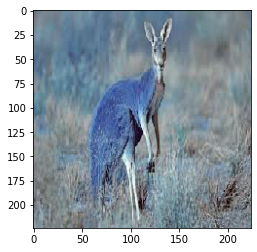

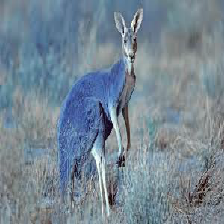

In [2]:
# Load example image and preprocess, and view
image_path = "./material/kangaroo.jpg"
img = load_img(image_path)
visualize_img(img[0])

In [3]:
# prepare the original model
model = vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# prepare the feature map model
for i, layer in enumerate(model.layers):
    print("{}:\t{}".format(i, layer))
lyid_feature_maps =list(range(1, 15))
fm_model = get_fm_model(model, ixs_layers=lyid_feature_maps)
fm_model.summary()


0:	<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f614438c460>
1:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d351b8e0>
2:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d351bd30>
3:	<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f60d14524c0>
4:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d149a9d0>
5:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d145dc10>
6:	<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f60d14646d0>
7:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d1464bb0>
8:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d01f1790>
9:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d01f3af0>
10:	<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f60d01f1d60>
11:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f60d01f35b0>
12:	<tensorf

In [5]:

# see fmaps
feature_maps = fm_model.predict(img)
# plot_feature_maps(feature_maps)

In [6]:
# get deconv model
i_layer = 14
deconv_model = get_deconv_model(model, n_layers=i_layer,
                                current_feature_maps=feature_maps,
                                lyid_feature_maps=lyid_feature_maps)
deconv_model.summary()

Model: "deconv2d_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_un_pooling (MaxUnPooling (None, 28, 28, 512)       0         
_________________________________________________________________
reverse_bias_layer (ReverseB (None, 28, 28, 512)       0         
_________________________________________________________________
deconv2d (Deconv2D)          (None, 28, 28, 512)       2359808   
_________________________________________________________________
reverse_bias_layer_1 (Revers (None, 28, 28, 512)       0         
_________________________________________________________________
deconv2d_1 (Deconv2D)        (None, 28, 28, 512)       2359808   
_________________________________________________________________
reverse_bias_layer_2 (Revers (None, 28, 28, 512)       0         
_________________________________________________________________
deconv2d_2 (Deconv2D)        (None, 28, 28, 256)    

In [7]:
# get fmap as input
i_fmap = lyid_feature_maps.index(i_layer)
fmap = feature_maps[i_fmap]
print(fmap.shape)


(1, 14, 14, 512)


(224, 224, 3)


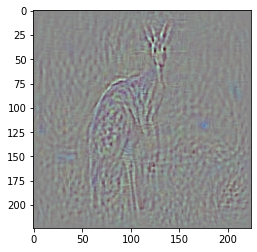

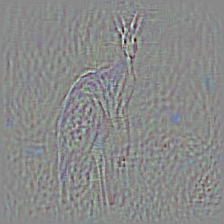

In [8]:
# test it
img_re = deconv_model.predict(fmap)[0]
visualize_img(img_re)


(14, 14)
(1, 14, 14, 512)
(224, 224, 3)


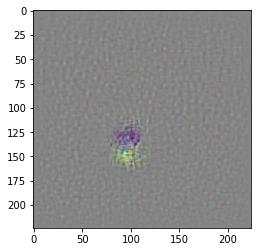

(99, 99, 3)


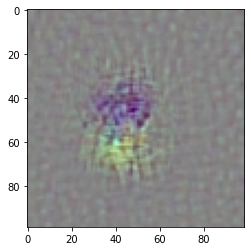

(99, 99, 3)


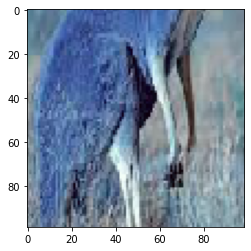

In [10]:
i_filter = 10
show_reconstruct_pattern(deconv_model, fmap, img[0], i_filter)

(14, 14)
(1, 14, 14, 512)
(224, 224, 3)


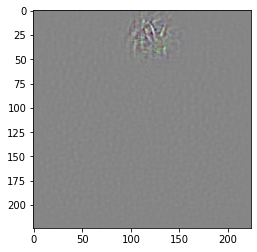

(73, 99, 3)


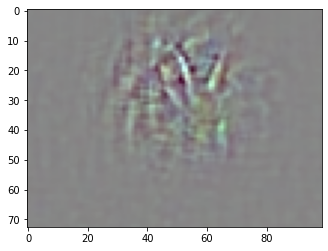

(73, 99, 3)


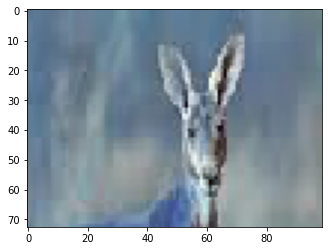

In [9]:
# most interesting i_filter
show_reconstruct_pattern(deconv_model, fmap, img[0])